In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.linalg import expm, fractional_matrix_power

import networkx as nx
import igraph as ig

from utils.Multiscale.load_data import load_dict
from utils.Multiscale.multiscale_functions import *
from netneurotools import plotting
from netneurotools.metrics import communicability_bin, communicability_wei

import utils.CommonFunctions as cf
import utils.plotter as plotter

# Data visualization

In [5]:
data = load_dict('data/LAU1000')

In [6]:
data['sc'].shape

(1000, 1000)

In [22]:
data.keys()

dict_keys(['sc', 'fc', 'coords', 'lhannot', 'rhannot', 'noplot', 'order', 'rsn', 'rsn_names', 've', 've_names', 'ci'])

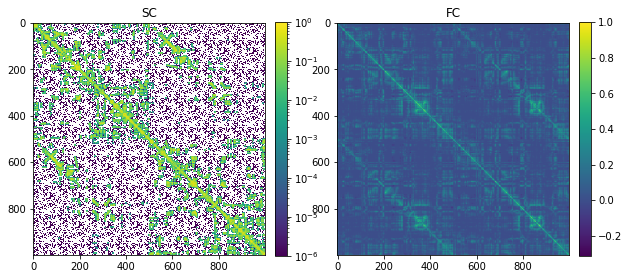

In [27]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,2,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.show()

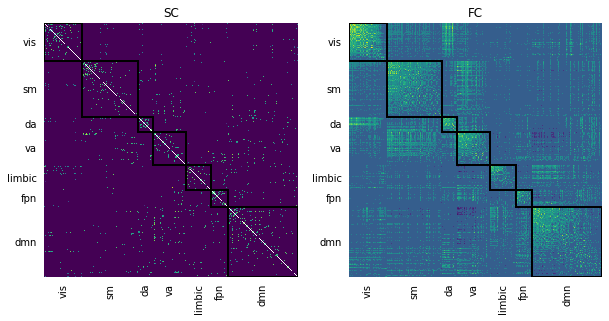

In [29]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
plotting.plot_mod_heatmap(data['sc'], data['rsn'], ax=ax1, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'])
plt.title('SC')

ax2 = plt.subplot(1,2,2)
plotting.plot_mod_heatmap(data['fc'], data['rsn'], ax=ax2, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'])
plt.title('FC')

plt.show()

In [95]:
def diffusion_distance(mat, t):
    num_nodes = len(mat)
    
    lapl = laplacian_matrix(mat)
    expL = expm(-lapl*t)

    d_ij = np.zeros((num_nodes,num_nodes))
    
    for i in range(0, num_nodes):
        for j in range(i+1, num_nodes):
            d_ij_tmp = expL[i] - expL[j]
            d_ij[i,j] = np.sqrt(d_ij_tmp.dot(d_ij_tmp))
            
    return d_ij + d_ij.T

In [96]:
ts = [[1, 2, 5, 10, 20], [40, 50, 60, 100, 200]]
ts = np.array(ts)

res = []

for i,t in enumerate(ts.flatten()):
    print('* {}/{} - t={}'.format(i+1,len(ts.flatten()),t))
    tmp = diffusion_distance(data['sc'], t=t)
    res.append(tmp)

* 1/10 - t=1
* 2/10 - t=2
* 3/10 - t=5
* 4/10 - t=10
* 5/10 - t=20
* 6/10 - t=40
* 7/10 - t=50
* 8/10 - t=60
* 9/10 - t=100
* 10/10 - t=200


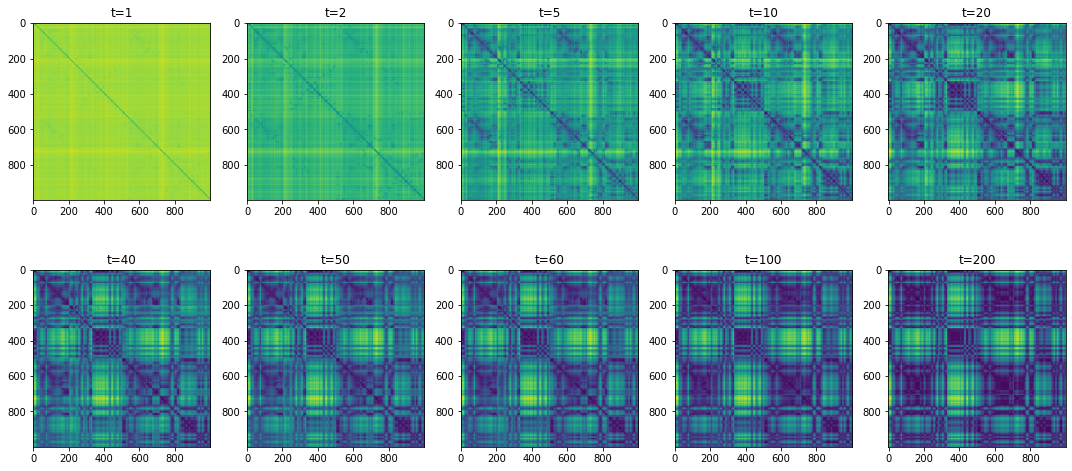

In [97]:
ts = [[1, 2, 5, 10, 20], [40, 50, 60, 100, 200]]
ts = np.array(ts)

plt.figure(figsize=(15,7))

for (x,y), t in np.ndenumerate(ts):
    ax = plt.subplot(ts.shape[0],ts.shape[1],x*ts.shape[1]+y+1)
    plt.imshow(res[x*ts.shape[1]+y])
    plt.title('t='+str(t))
    
plt.tight_layout()
plt.show()

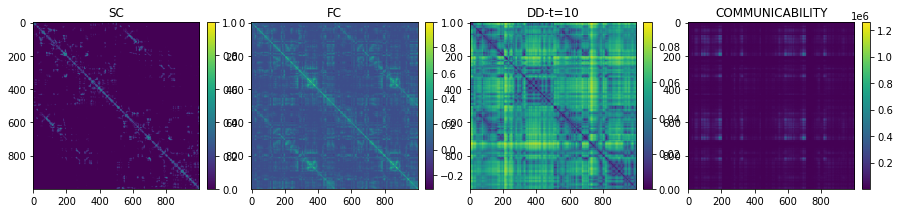

In [98]:
tt = 3

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(data['sc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(res[tt])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('DD-t='+str(ts.flatten()[tt]))

plt.subplot(1,4,4)
plt.imshow(communicability(data['sc']))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.show()

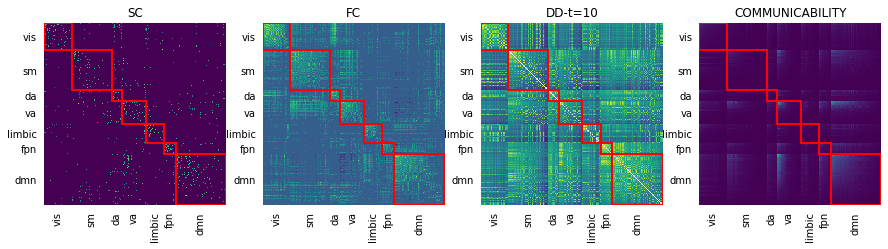

In [104]:
tt = 3

plt.figure(figsize=(15,15))

ax = plt.subplot(1,4,1)
plotting.plot_mod_heatmap(data['sc'], data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax = plt.subplot(1,4,2)
plotting.plot_mod_heatmap(data['fc'], data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

ax = plt.subplot(1,4,3)
plotting.plot_mod_heatmap(np.max(res[tt])-res[tt], data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('DD-t='+str(ts.flatten()[tt]))

ax = plt.subplot(1,4,4)
plotting.plot_mod_heatmap(communicability(data['sc']), data['rsn'], ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('COMMUNICABILITY')

plt.show()

# Community detection
see https://igraph.org/python/api/develop/igraph.community.html for clustering methods <br>
see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for evaluation metrics

In [138]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score

In [105]:
# Louvain
# Spectral clustering
# Spin glass
# Infomap
# Manlio

In [139]:
def community_detection(mat, method):
    graph = ig.Graph.Weighted_Adjacency(mat.tolist(), mode=ig.ADJ_UNDIRECTED, attr="weight", loops=False)
    
    if method == 'louvain':
        comms = graph.community_multilevel(weights=graph.es['weight'], return_levels=False)
    elif method == 'leiden':
        comms = graph.community_leiden(weights=graph.es['weight'], resolution_parameter=1.0, n_iterations=-1) #objective_function: Constant Potts Model (CPM) or modularity
    elif method == 'spin_glass':
        comms = graph.community_spinglass(weights=graph.es['weight'], spins=int(1e3))
    elif method == 'infomap':
        comms = graph.community_infomap(edge_weights=graph.es['weight'], trials=10)
    else:
        raise( Exception('Community detection method not defined.\n'))
    
    return comms.membership

def metrics(comms_true, comms_emp, method):
    if method == 'nmi':
        score = normalized_mutual_info_score(comms_true, comms_emp)
    elif method == 'ami':
        score = adjusted_mutual_info_score(comms_true, comms_emp)
    elif method == 'ari':
        score = adjusted_rand_score(comms_true, comms_emp)
    else:
        raise(Exception('Evaluation method not defined.\n'))
    
    return score

In [ ]:
comms = []
mats = [data['sc'], communicability(data['sc'])]
mat_names = ['SC', 'CC']
methods = ['louvain', 'spin_glass', 'infomap']
scores = ['nmi', 'ami', 'ari']


for i, mat in enumerate(mats):
    print('[*] MATRIX: '+str(mat_names[i]))
    tmp_comms, tmp_scores = [], []
    
    for method in methods:
        print('[+] method: '+str(method))
        Q = community_detection(mat, method)
        tmp_comms.append(Q)
    comms.append(tmp_comms)

[*] MATRIX: SC
[+] method: louvain
[+] method: spin_glass
[+] method: infomap
[*] MATRIX: CC
[+] method: louvain
